In [1]:
## Setting up environments
import os
import json
import numpy as np
import pandas as pds
from copy import deepcopy
from random import shuffle, randint, uniform

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

**Note**: networkx, scipy, and scikit-learn packages are needed in this demonstration

In [2]:
import sys
sys.path.insert(0, './')
from Pareto import *
from basics import *
from network_mvc import *

matplotlib.rcParams['font.family'] = "Sans-serif"
matplotlib.rcParams['font.serif'] = "Arial" # Helvetica
matplotlib.rcParams['font.style'] = "normal"
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['mathtext.fontset'] = "custom"
matplotlib.rcParams['mathtext.rm'] = "Arial"

In [3]:
## To construct graphs
import networkx as nx
## To calculate correlations
from scipy.stats import pearsonr

# Correlation graphs of properties and identify representative properties


In [4]:
## Get the color for each type of MLIP
modelcolor = {}
for m, n in zip(model_label_csv['Models'], model_label_csv['Color']):
    modelcolor[m] = n

## Get the color for each category of properties
propertycolor = {}
for m, n in zip(category_label_csv['Categories'], category_label_csv['color']):
    propertycolor[m] = n

## We need normalized log errors to calculate correlations
norm_log_data = pds.read_csv('data/normalized_log_errors.csv').drop(columns=['Unnamed: 0'])
norm_log_data.head()

,Models,ModelName,SelectionType,TrainingData,hex_Ef,spl_Ef,tet_Ef,vac_Ef,spl_c11,spl_c12,...,Vacancy_enhanced_E,Vacancy_enhanced_F,Vacancy_RE_E,Vacancy_RE_F,bulk_free_energy,bulk_entropy,bulk_heat_capacity,vacancy_free_energy,vacancy_entropy,vacancy_heat_capacity
0,DFT,Threshold,NaN,NaN,0.504750,0.855112,-0.060705,-0.280528,-0.953033,-0.778269,...,0.236210,-0.761779,0.988656,-1.160869,-0.901101,-1.023010,-0.904197,0.029467,0.226656,0.411471
1,GAP,183-3,s,Org,0.780239,0.611954,0.804912,-1.120803,-0.288999,-0.790659,...,-1.175896,-1.307301,-0.480432,-1.149233,-1.401489,-1.171511,-1.077526,-1.658051,-1.715457,-0.614198
2,GAP,189-5,s,Org,0.850402,0.600587,0.770690,-1.107595,-0.271309,-0.618390,...,-1.219224,-1.348496,-0.524035,-1.198054,-0.922067,-0.831668,-0.992529,-1.102494,-0.823288,-0.556851
3,GAP,341-5,r,Org,0.523894,0.261400,0.071620,-0.302134,-0.177400,-0.673296,...,-0.721812,-0.769159,-0.099455,-0.823599,-1.760735,-1.822453,-0.888281,0.020416,0.173741,0.247983
4,GAP,58-2,r,Org,-0.112582,0.305990,0.316971,-0.145629,-0.351548,-0.823457,...,-0.909181,-1.040954,-0.194338,-0.850400,-1.379172,-1.105195,-0.913820,-1.769730,-1.191872,-0.632313


In [5]:
## Get the color for each property
properties = [n for n in property_label_csv['Properties']]
node_color = []
for p, c in zip(properties, property_label_csv['Category']):
    node_color.append(propertycolor[c])

In [50]:
mlip = 'SNAP' ## the selected type of MLIP

if mlip.lower()=='full':
    df = deepcopy(norm_log_data) ## all MLIPs
else:
    df = norm_log_data.loc[norm_log_data['Models']==mlip]

## the correlation matrix
## all pearson correlation's r2 values
corr_matrix = np.ones((len(properties), len(properties)))
for ipx, px in enumerate(properties):
    for ipy, py in enumerate(properties):
        if ipx!=ipy:
            ## Pearson's r
            r, _ = pearsonr(df[px], df[py])
            corr_matrix[ipx][ipy] = r**2

**Note**: after this step, we directly load calculated data of representative properties and draw correlation graphs if one doesn't want to do the calculations. <u>Simply skip to the cell which opens json files below</u>.

In [51]:
## Only connect the properties whose r2 > threshold
threshold = 0.6 

## Construct the property correlation graph
base = nx.Graph()
base.add_nodes_from(properties, color=node_color)
for ipx, px in enumerate(properties[:-1]):
    for py in properties[ipx+1:]:
        ipy = properties.index(py)
        r2 = corr_matrix[ipx][ipy]
        if r2>threshold:
            base.add_edge(px, py, r2=r2)

In [52]:
## Compute the representative properties
selected_nodes = []
isolated_nodes = []
cleaned_graph, isolated_nodes = cleanGraph(base)
print('Cleaned:', len(cleaned_graph.nodes), '(check consistency)')
selected_nodes = deepcopy(simplePageRankMVC(cleaned_graph, mvc_list=[]))
print('Selected:', len(selected_nodes))
print('Isolated:', len(isolated_nodes))
print('All:', len(base.nodes))

## all selected and isolated nodes are representative
for iso in isolated_nodes:
    selected_nodes.append(iso)
print('Representative:', len(selected_nodes))

Cleaned: 44 (check consistency)
Selected: 13
Isolated: 16
All: 60
Representative: 29


In [53]:
## Get the coordinates of all nodes
pos = nx.nx_agraph.graphviz_layout(base, prog="neato", args="-Gmaxiter=100")

## Get the coordinates of representative properties
rep_pos = {}
for node in selected_nodes:
    rep_pos[node] = pos[node]

In [54]:
## Store the coordinates and correlation matrix because 'neato' generates random coordinates
outfile = 'data/Fig7/{}_rep.json'.format(mlip)
output = open(outfile, 'w')
json.dump([pos, rep_pos, corr_matrix.tolist()], output)
output.close()

In [55]:
"""
    We can skip the above steps and draw graphs directly here.
"""
 
with open('data/Fig7/{}_rep.json'.format(mlip), 'r') as file:
    total_pos, repre_pos, corr = json.load(file)
file.close()

In [56]:
## the graph of all properties
threshold = 0.6 
new = nx.Graph()
new.add_nodes_from(properties, color=node_color)
for ipx, px in enumerate(properties[:-1]):
    for py in properties[ipx+1:]:
        ipy = properties.index(py)
        r2 = corr[ipx][ipy]
        ## only connect properties having r2 > threshold
        if r2>threshold:
            new.add_edge(px, py, r2=r2)

In [57]:
## the graph of representative properties
## Get the colors of representative nodes
rep_color = []
for node in repre_pos.keys():
    pi = properties.index(node)
    c = property_label_csv['Category'][pi]
    rep_color.append(propertycolor[c])

rep = nx.Graph()
rep.add_nodes_from(repre_pos, color=rep_color)

X: 32 710
Y: 18 710


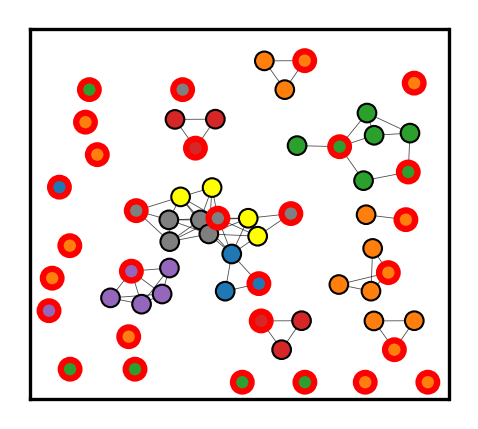

In [58]:
fig = plt.figure(figsize=(1.8, 1.6), dpi=300)
ax = plt.subplot(1, 1, 1)

## Draw all properties
nx.draw_networkx_nodes(new, pos=total_pos, node_size=20, linewidths=0.5,
                       node_color=node_color, edgecolors='black')
## Draw representative properties (red edges)
nx.draw_networkx_nodes(rep, pos=repre_pos, node_size=20, linewidths=1.5,
                       node_color=rep_color, edgecolors='red')
## Draw relation edges
nx.draw_networkx_edges(new, pos=total_pos, width=0.2, alpha=0.7)

## Show the coordinates of the graph
pos_data = [total_pos[k] for k in total_pos.keys()]
print('X:', round(min([n[0] for n in pos_data])), round(max([n[0] for n in pos_data])))
print('Y:', round(min([n[1] for n in pos_data])), round(max([n[1] for n in pos_data])))

plt.show()
plt.clf()
plt.close()